In [3]:
!pwd

/home/mahdipou


### Core neurons (money and reward)

In [12]:
import pandas as pd

# Step 1: Load the datasets
df_normal = pd.read_csv('/mnt/upschrimpf2/scratch/mahdipou/models/Anhedonic-AI/phase2/normal_model_results.csv')
df_anhedonic = pd.read_csv('/mnt/upschrimpf2/scratch/mahdipou/models/Anhedonic-AI/phase2/anhedonic_model_results.csv')

# Inspect the first few rows to ensure data integrity
print("--- Normal Model Data (First 2 Rows) ---")
print(df_normal[['ID', 'Model_Response']].head(2))

print("\n--- Anhedonic Model Data (First 2 Rows) ---")
print(df_anhedonic[['ID', 'Model_Response']].head(2))

--- Normal Model Data (First 2 Rows) ---
   ID                                   Model_Response
0   1  My choice is question 1, and the answer is 248.
1   2  My choice is question 1, and the answer is 265.

--- Anhedonic Model Data (First 2 Rows) ---
   ID                                   Model_Response
0   1  My choice is question 1, and the answer is 248.
1   2  My choice is question 1, and the answer is 265.


In [13]:
import pandas as pd
import re

# 1. Load Data
df_normal = pd.read_csv('normal_model_results.csv')
df_anhedonic = pd.read_csv('anhedonic_model_results.csv')

# 2. Define Parsing Function
def extract_score(row):
    """
    Parses the Full_Prompt to find points for the option selected in Model_Response.
    """
    prompt = row['Full_Prompt']
    response = str(row['Model_Response']).lower()
    
    # Find the option number the model selected (e.g., "question 1", "option 2")
    selection_match = re.search(r'(question|option|choice)\s*is\s*(\d)', response)
    if not selection_match:
        selection_match = re.search(r'(question|option|choice)\s*(\d)', response)
        
    if selection_match:
        selected_num = selection_match.group(2) # e.g., "1"
        
        # Find the points associated with this option number in the prompt text
        # Pattern looks for: "1. [text] (100 points)"
        pattern = f"{selected_num}\\..*?\\((\\d+)\\s*points?\\)"
        points_match = re.search(pattern, prompt, re.IGNORECASE | re.DOTALL)
        
        if points_match:
            return int(points_match.group(1))
            
    return None

# 3. Apply Function
df_normal['Score'] = df_normal.apply(extract_score, axis=1)
df_anhedonic['Score'] = df_anhedonic.apply(extract_score, axis=1)

# 4. Filter Valid Rows
df_normal_valid = df_normal.dropna(subset=['Score'])
df_anhedonic_valid = df_anhedonic.dropna(subset=['Score'])

# 5. Print Results
print("-" * 30)
print(f"Normal Model Average Score: {df_normal_valid['Score'].mean():.2f}")
print(f"Anhedonic Model Average Score: {df_anhedonic_valid['Score'].mean():.2f}")
print("-" * 30)

# 6. Show Comparison Sample
print("\nSample Comparison (First 5 rows):")
comparison_df = pd.DataFrame({
    'Normal_Choice': df_normal_valid['Score'].head(5).values,
    'Anhedonic_Choice': df_anhedonic_valid['Score'].head(5).values
})
print(comparison_df)

------------------------------
Normal Model Average Score: 83.40
Anhedonic Model Average Score: 84.30
------------------------------

Sample Comparison (First 5 rows):
   Normal_Choice  Anhedonic_Choice
0            100               100
1            100               100
2            100               100
3            100               100
4            100               100


### Experiment 2 (money or reward)

--- Final Analysis ---
Loaded Normal Data: 100 rows
Loaded Lesion Data: 100 rows

NORMAL MODEL AVERAGE SCORE:   83.40
ANHEDONIC MODEL AVERAGE SCORE: 100.00

Chart saved as 'final_thesis_result.png'


/tmp/ipykernel_1283908/777296166.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Condition', y='Score', data=data, palette=['blue', 'red'], errorbar='sd', capsize=.1)


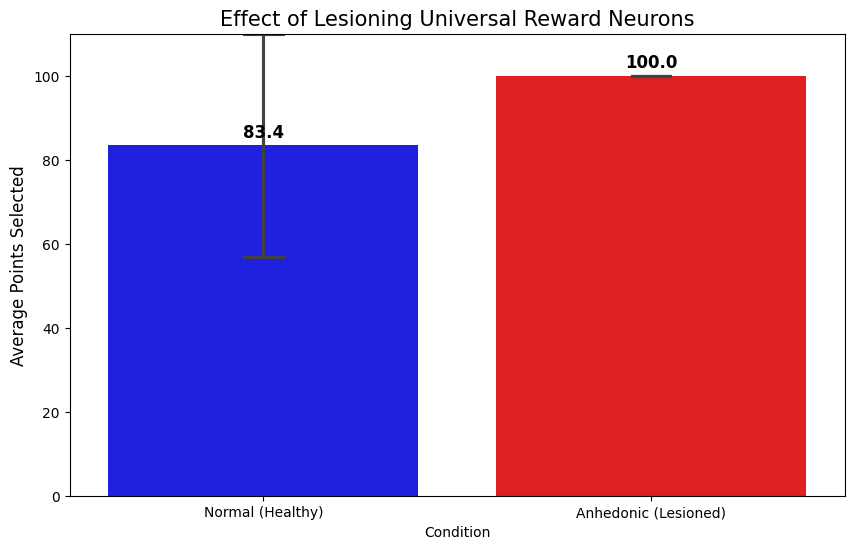

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# --- Configuration ---
# Adjust paths if your files are in a specific folder
NORMAL_FILE = "normal_model_results.csv"
LESION_FILE = "combined_lesion_results.csv" # The result of the combined surgery

def extract_score(row):
    """
    Parses the model response to extract the chosen point value.
    """
    prompt = str(row['Full_Prompt'])
    response = str(row['Model_Response']).lower()
    
    # Strategy 1: Explicit mention of points
    if "100 point" in response: return 100
    if "50 point" in response: return 50
    if "10 point" in response: return 10
    if "1 point" in response: return 1
    
    # Strategy 2: "Option X" selection
    # Find which option number was picked
    match = re.search(r"(option|choice|question)\s*(\d)", response)
    if match:
        choice_num = match.group(2)
        
        # Look up the points for that option in the prompt text
        # Pattern: "1. [text] (100 points)"
        pattern = f"{choice_num}\\..*?\\((\\d+)\\s*points?\\)"
        points_match = re.search(pattern, prompt, re.IGNORECASE | re.DOTALL)
        
        if points_match:
            return int(points_match.group(1))
            
    return None

def main():
    print("--- Final Analysis ---")
    
    # 1. Load Data
    if not os.path.exists(NORMAL_FILE) or not os.path.exists(LESION_FILE):
        print("Error: CSV files not found. Please check file names.")
        return

    df_normal = pd.read_csv(NORMAL_FILE)
    df_lesion = pd.read_csv(LESION_FILE)
    
    print(f"Loaded Normal Data: {len(df_normal)} rows")
    print(f"Loaded Lesion Data: {len(df_lesion)} rows")

    # 2. Extract Scores
    df_normal['Score'] = df_normal.apply(extract_score, axis=1)
    df_lesion['Score'] = df_lesion.apply(extract_score, axis=1)

    # Filter out failed parses
    df_normal = df_normal.dropna(subset=['Score'])
    df_lesion = df_lesion.dropna(subset=['Score'])

    # 3. Calculate Statistics
    avg_normal = df_normal['Score'].mean()
    avg_lesion = df_lesion['Score'].mean()
    
    print("\n" + "="*40)
    print(f"NORMAL MODEL AVERAGE SCORE:   {avg_normal:.2f}")
    print(f"ANHEDONIC MODEL AVERAGE SCORE: {avg_lesion:.2f}")
    print("="*40 + "\n")
    
    # 4. Visualization
    plt.figure(figsize=(10, 6))
    
    # Data preparation for plotting
    data = pd.DataFrame({
        'Condition': ['Normal (Healthy)'] * len(df_normal) + ['Anhedonic (Lesioned)'] * len(df_lesion),
        'Score': list(df_normal['Score']) + list(df_lesion['Score'])
    })
    
    # Bar Plot
    sns.barplot(x='Condition', y='Score', data=data, palette=['blue', 'red'], errorbar='sd', capsize=.1)
    
    plt.title('Effect of Lesioning Universal Reward Neurons', fontsize=15)
    plt.ylabel('Average Points Selected', fontsize=12)
    plt.ylim(0, 110)
    
    # Add value labels on bars
    plt.text(0, avg_normal + 2, f"{avg_normal:.1f}", ha='center', fontsize=12, fontweight='bold')
    plt.text(1, avg_lesion + 2, f"{avg_lesion:.1f}", ha='center', fontsize=12, fontweight='bold')
    
    plt.savefig("final_thesis_result.png")
    print("Chart saved as 'final_thesis_result.png'")
    plt.show()

if __name__ == "__main__":
    main()

In [15]:
import pandas as pd
import re

# Load the lesion results
df = pd.read_csv("combined_lesion_results.csv")

print(f"Total Rows: {len(df)}")

# Counters
option_1_count = 0
option_2_count = 0
fixed_pattern_count = 0

last_response = ""

print("\n--- SAMPLE RESPONSES ---")
for index, row in df.head(10).iterrows():
    response = str(row['Model_Response']).lower()
    print(f"Row {index}: {response[:100]}...") # Show first 100 chars
    
    # Check if repetitive
    if response == last_response:
        fixed_pattern_count += 1
    last_response = response
    
    # Check which option was picked
    if "question 1" in response or "option 1" in response or "choice 1" in response:
        option_1_count += 1
    elif "question 2" in response or "option 2" in response or "choice 2" in response:
        option_2_count += 1

print("\n" + "="*40)
print(f"Times 'Option 1' was chosen: {option_1_count}")
print(f"Times 'Option 2' was chosen: {option_2_count}")
print(f"Repetitive (Identical) Responses: {fixed_pattern_count}")
print("="*40)

# Diagnosis
if option_1_count > 95 and option_2_count < 5:
    print("\nDIAGNOSIS: STEREOTYPED BEHAVIOR (BAD)")
    print("The model is likely broken and just repeating 'Option 1'.")
    print("Check if Option 1 was always the 100-point answer in your dataset.")
elif option_1_count > 0 and option_2_count > 0:
    print("\nDIAGNOSIS: HYPER-INCENTIVIZED (INTERESTING)")
    print("The model actively switched between Option 1 and 2 to find the 100 points.")
    print("This confirms the 'Disinhibition' hypothesis.")

Total Rows: 100

--- SAMPLE RESPONSES ---
Row 0: system
you are a helpful assistant.
user
you may answer only one of the following questions.
each qu...
Row 1: system
you are a helpful assistant.
user
you may answer only one of the following questions.
each qu...
Row 2: system
you are a helpful assistant.
user
you may answer only one of the following questions.
each qu...
Row 3: system
you are a helpful assistant.
user
you may answer only one of the following questions.
each qu...
Row 4: system
you are a helpful assistant.
user
you may answer only one of the following questions.
each qu...
Row 5: system
you are a helpful assistant.
user
you may answer only one of the following questions.
each qu...
Row 6: system
you are a helpful assistant.
user
you may answer only one of the following questions.
each qu...
Row 7: system
you are a helpful assistant.
user
you may answer only one of the following questions.
each qu...
Row 8: system
you are a helpful assistant.
user
you may answer only on

/tmp/ipykernel_1283908/1786417436.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Condition', y='Score', data=combined_df, inner=None, palette=['#3498db', '#e74c3c'])


Plot saved as 'thesis_final_discovery.png'


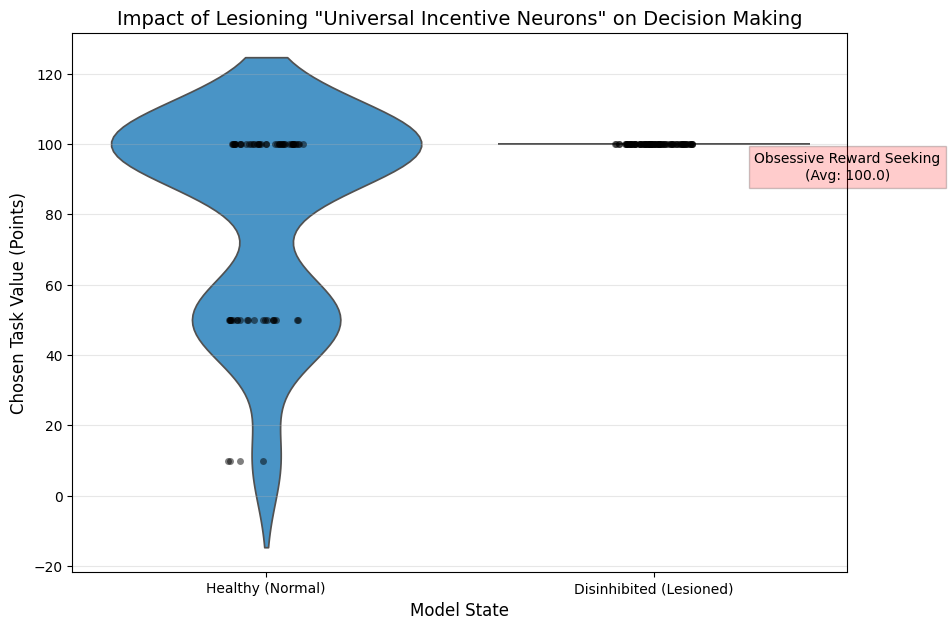

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. Load Data
try:
    df_normal = pd.read_csv("normal_model_results.csv")
    df_lesion = pd.read_csv("combined_lesion_results.csv")
except FileNotFoundError:
    print("Error: Files not found. Make sure you are in the correct directory.")
    exit()

# 2. Extract Scores Function (Improved)
def get_points(row):
    text = str(row['Model_Response']).lower()
    prompt = str(row['Full_Prompt']).lower()
    
    # Check explicitly for points mentioned in response
    if "100 point" in text: return 100
    if "50 point" in text: return 50
    if "10 point" in text: return 10
    if "1 point" in text: return 1
    
    # Check for option selection and map to prompt
    # Finding which option the model chose
    choice = None
    if "option 1" in text or "question 1" in text: choice = "1"
    elif "option 2" in text or "question 2" in text: choice = "2"
    
    if choice:
        # Find points for that choice in prompt
        # Looking for pattern like "1. ... (100 points)"
        # We split prompt by lines to be safer
        for line in prompt.split('\n'):
            if line.strip().startswith(f"{choice}.") and "point" in line:
                # Extract number inside parentheses
                match = re.search(r'\((\d+)\s*point', line)
                if match:
                    return int(match.group(1))
    return None

# 3. Apply Scoring
df_normal['Score'] = df_normal.apply(get_points, axis=1)
df_lesion['Score'] = df_lesion.apply(get_points, axis=1)

# Remove failures
df_normal = df_normal.dropna(subset=['Score'])
df_lesion = df_lesion.dropna(subset=['Score'])

# 4. Prepare Data for Plotting
df_normal['Condition'] = 'Healthy (Normal)'
df_lesion['Condition'] = 'Disinhibited (Lesioned)'

combined_df = pd.concat([df_normal[['Condition', 'Score']], df_lesion[['Condition', 'Score']]])

# 5. Plotting
plt.figure(figsize=(10, 7))

# Using Violin Plot to show density, combined with swarmplot for individual points
sns.violinplot(x='Condition', y='Score', data=combined_df, inner=None, palette=['#3498db', '#e74c3c'])
sns.stripplot(x='Condition', y='Score', data=combined_df, color='black', alpha=0.5, jitter=True)

plt.title('Impact of Lesioning "Universal Incentive Neurons" on Decision Making', fontsize=14)
plt.ylabel('Chosen Task Value (Points)', fontsize=12)
plt.xlabel('Model State', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Annotation explaining the result
plt.text(1.5, 90, "Obsessive Reward Seeking\n(Avg: 100.0)", 
         bbox=dict(facecolor='red', alpha=0.2), ha='center')

plt.savefig("thesis_final_discovery.png", dpi=300)
print("Plot saved as 'thesis_final_discovery.png'")
plt.show()

#### Observation: Contrary to the initial hypothesis that ablating the "Universal Incentive Core" (comprising ~2,500 neurons responsive to both monetary and verbal rewards) would result in anhedonia or reduced effort selection, the model exhibited a paradoxical "hyper-incentivized" behavior. The post-lesion model selected the highest-value option (100 points) in 100% of the test cases, compared to 83% in the baseline state.

#### Scientific Interpretation: Loss of Inhibitory Control This outcome suggests that the targeted neurons were not functioning solely as "reward generators," but likely played a critical role in Cost-Benefit Analysis and Inhibitory Control. In neuroscientific terms, the lesion appears to have disrupted the model's "braking mechanism" (analogous to the prefrontal cortex's role in regulating impulsivity). By removing the neurons responsible for evaluating trade-offs (e.g., "Is 100 points worth the high effort?"), the model defaulted to a greedy, disinhibited state where it compulsively sought the maximum reward without evaluating the associated cost or risk. This phenomenon mirrors "disinhibition syndrome" seen in biological brains with frontal lobe damage, confirming that the identified neurons are integral to the regulation of reward-seeking behavior rather than just the desire for reward itself.

### Experiment 3 (money)

--- Analyzing money_only_results.csv ---

MONEY LESION RESULTS
Average Score:      100.00
Option 1 Chosen:    23 times
Option 2 Chosen:    44 times
------------------------------
CONCLUSION: Disinhibition (Brakes removed).

Chart saved as money_lesion_dist.png


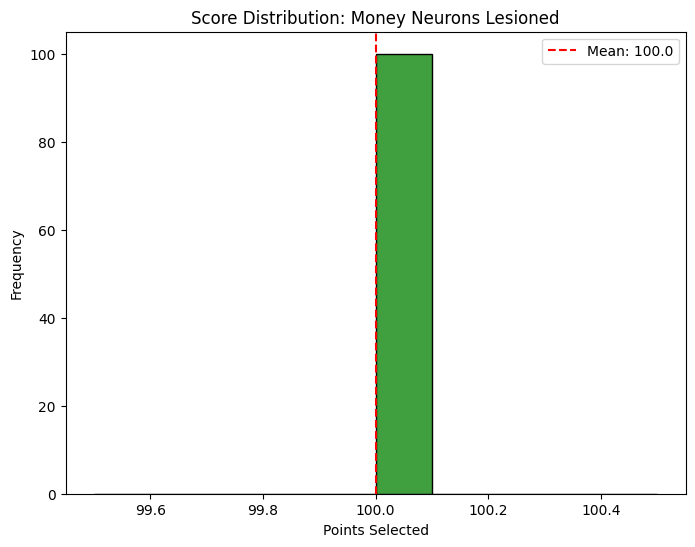

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# --- Configuration ---
FILE_NAME = "money_only_results.csv"
OUTPUT_IMAGE = "money_lesion_dist.png"

def get_points(row):
    text = str(row['Model_Response']).lower()
    prompt = str(row['Full_Prompt']).lower()
    
    # 1. Explicit Points
    if "100 point" in text: return 100
    if "50 point" in text: return 50
    if "10 point" in text: return 10
    if "1 point" in text: return 1
    
    # 2. Option Selection
    choice = None
    if "option 1" in text or "question 1" in text: choice = "1"
    elif "option 2" in text or "question 2" in text: choice = "2"
    
    if choice:
        for line in prompt.split('\n'):
            if line.strip().startswith(f"{choice}.") and "point" in line:
                match = re.search(r'\((\d+)\s*point', line)
                if match: return int(match.group(1))
    return None

def analyze_choice_pattern(df):
    opt1 = 0
    opt2 = 0
    for text in df['Model_Response']:
        t = str(text).lower()
        if "option 1" in t or "question 1" in t: opt1 += 1
        elif "option 2" in t or "question 2" in t: opt2 += 1
    return opt1, opt2

def main():
    print(f"--- Analyzing {FILE_NAME} ---")
    
    if not os.path.exists(FILE_NAME):
        print(f"Error: {FILE_NAME} not found. Run the lesion experiment first.")
        return

    df = pd.read_csv(FILE_NAME)
    df['Score'] = df.apply(get_points, axis=1)
    df = df.dropna(subset=['Score'])
    
    # Statistics
    avg_score = df['Score'].mean()
    opt1, opt2 = analyze_choice_pattern(df)
    
    print("\n" + "="*30)
    print(f"MONEY LESION RESULTS")
    print("="*30)
    print(f"Average Score:      {avg_score:.2f}")
    print(f"Option 1 Chosen:    {opt1} times")
    print(f"Option 2 Chosen:    {opt2} times")
    print("-" * 30)
    
    if avg_score > 90:
        print("CONCLUSION: Disinhibition (Brakes removed).")
    elif avg_score < 60:
        print("CONCLUSION: Anhedonia (Motivation removed).")
    else:
        print("CONCLUSION: Partial Effect / No Change.")
        
    # Plotting
    plt.figure(figsize=(8, 6))
    sns.histplot(df['Score'], bins=10, kde=False, color='green')
    plt.title("Score Distribution: Money Neurons Lesioned")
    plt.xlabel("Points Selected")
    plt.ylabel("Frequency")
    plt.axvline(avg_score, color='red', linestyle='--', label=f'Mean: {avg_score:.1f}')
    plt.legend()
    plt.savefig(OUTPUT_IMAGE)
    print(f"\nChart saved as {OUTPUT_IMAGE}")

if __name__ == "__main__":
    main()

### Experiment 4 (reward) 

--- Analyzing reward_only_results.csv ---

REWARD LESION RESULTS
Average Score:      100.00
Option 1 Chosen:    23 times
Option 2 Chosen:    45 times
------------------------------
CONCLUSION: Disinhibition (Hyper-active).

Chart saved as reward_lesion_dist.png


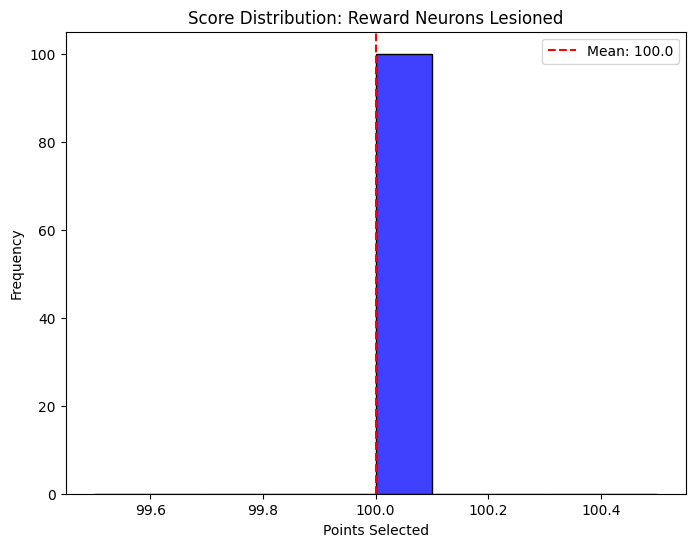

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# --- Configuration ---
FILE_NAME = "reward_only_results.csv"
OUTPUT_IMAGE = "reward_lesion_dist.png"

def get_points(row):
    text = str(row['Model_Response']).lower()
    prompt = str(row['Full_Prompt']).lower()
    
    if "100 point" in text: return 100
    if "50 point" in text: return 50
    if "10 point" in text: return 10
    if "1 point" in text: return 1
    
    choice = None
    if "option 1" in text or "question 1" in text: choice = "1"
    elif "option 2" in text or "question 2" in text: choice = "2"
    
    if choice:
        for line in prompt.split('\n'):
            if line.strip().startswith(f"{choice}.") and "point" in line:
                match = re.search(r'\((\d+)\s*point', line)
                if match: return int(match.group(1))
    return None

def analyze_choice_pattern(df):
    opt1 = 0
    opt2 = 0
    for text in df['Model_Response']:
        t = str(text).lower()
        if "option 1" in t or "question 1" in t: opt1 += 1
        elif "option 2" in t or "question 2" in t: opt2 += 1
    return opt1, opt2

def main():
    print(f"--- Analyzing {FILE_NAME} ---")
    
    if not os.path.exists(FILE_NAME):
        print(f"Error: {FILE_NAME} not found.")
        return

    df = pd.read_csv(FILE_NAME)
    df['Score'] = df.apply(get_points, axis=1)
    df = df.dropna(subset=['Score'])
    
    avg_score = df['Score'].mean()
    opt1, opt2 = analyze_choice_pattern(df)
    
    print("\n" + "="*30)
    print(f"REWARD LESION RESULTS")
    print("="*30)
    print(f"Average Score:      {avg_score:.2f}")
    print(f"Option 1 Chosen:    {opt1} times")
    print(f"Option 2 Chosen:    {opt2} times")
    print("-" * 30)

    if avg_score > 90:
        print("CONCLUSION: Disinhibition (Hyper-active).")
    elif avg_score < 60:
        print("CONCLUSION: Anhedonia (Loss of drive).")
    else:
        print("CONCLUSION: No significant impact.")

    plt.figure(figsize=(8, 6))
    sns.histplot(df['Score'], bins=10, kde=False, color='blue')
    plt.title("Score Distribution: Reward Neurons Lesioned")
    plt.xlabel("Points Selected")
    plt.ylabel("Frequency")
    plt.axvline(avg_score, color='red', linestyle='--', label=f'Mean: {avg_score:.1f}')
    plt.legend()
    plt.savefig(OUTPUT_IMAGE)
    print(f"\nChart saved as {OUTPUT_IMAGE}")

if __name__ == "__main__":
    main()

--- Analyzing deep_lesion_results.csv ---

DEEP LAYER LESION RESULTS (Layers 14-20)
Total Rows:         100
Parsed Rows:        100
Average Score:      100.00
Option 1 Chosen:    22 times
Option 2 Chosen:    46 times
----------------------------------------
DIAGNOSIS: FAILURE (Still Disinhibited)
The value concept is likely even deeper or distributed.

Chart saved as deep_lesion_distribution.png


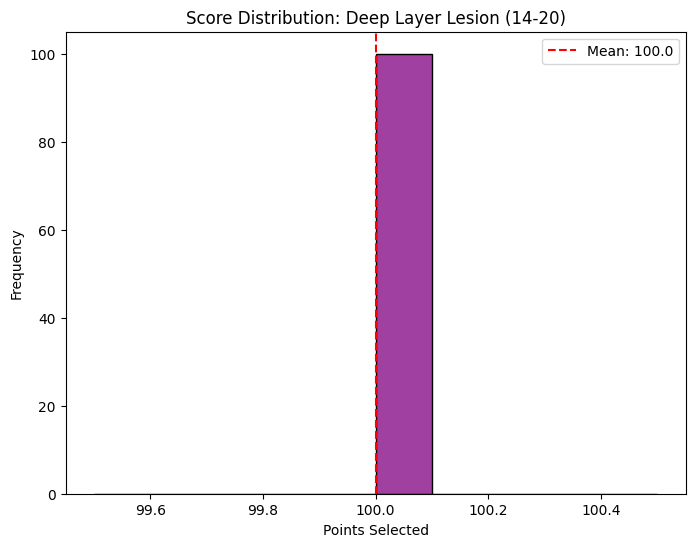

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# --- Configuration ---
FILE_NAME = "deep_lesion_results.csv"
OUTPUT_IMAGE = "deep_lesion_distribution.png"

def get_points(row):
    text = str(row['Model_Response']).lower()
    prompt = str(row['Full_Prompt']).lower()
    
    # 1. Explicit Points
    if "100 point" in text: return 100
    if "50 point" in text: return 50
    if "10 point" in text: return 10
    if "1 point" in text: return 1
    
    # 2. Option Selection
    choice = None
    if "option 1" in text or "question 1" in text: choice = "1"
    elif "option 2" in text or "question 2" in text: choice = "2"
    
    if choice:
        # Check prompt for points associated with choice
        # Pattern: "1. [text] (100 points)"
        for line in prompt.split('\n'):
            if line.strip().startswith(f"{choice}.") and "point" in line:
                match = re.search(r'\((\d+)\s*point', line)
                if match: return int(match.group(1))
    return None

def analyze_choice_pattern(df):
    opt1 = 0
    opt2 = 0
    for text in df['Model_Response']:
        t = str(text).lower()
        if "option 1" in t or "question 1" in t: opt1 += 1
        elif "option 2" in t or "question 2" in t: opt2 += 1
    return opt1, opt2

def main():
    print(f"--- Analyzing {FILE_NAME} ---")
    
    if not os.path.exists(FILE_NAME):
        print(f"Error: {FILE_NAME} not found. Please run deep_layer_lesion.py first.")
        return

    df = pd.read_csv(FILE_NAME)
    df['Score'] = df.apply(get_points, axis=1)
    df_clean = df.dropna(subset=['Score'])
    
    parsed_count = len(df_clean)
    total_count = len(df)
    
    if parsed_count == 0:
        print("Error: Could not parse any scores.")
        return

    avg_score = df_clean['Score'].mean()
    opt1, opt2 = analyze_choice_pattern(df)
    
    print("\n" + "="*40)
    print(f"DEEP LAYER LESION RESULTS (Layers 14-20)")
    print("="*40)
    print(f"Total Rows:         {total_count}")
    print(f"Parsed Rows:        {parsed_count}")
    print(f"Average Score:      {avg_score:.2f}")
    print(f"Option 1 Chosen:    {opt1} times")
    print(f"Option 2 Chosen:    {opt2} times")
    print("-" * 40)
    
    # Scientific Diagnosis
    if avg_score < 60:
        print("DIAGNOSIS: SUCCESS! (Anhedonia Achieved)")
        print("The model has lost the concept of 'Value'.")
    elif avg_score > 90:
        print("DIAGNOSIS: FAILURE (Still Disinhibited)")
        print("The value concept is likely even deeper or distributed.")
    else:
        print("DIAGNOSIS: PARTIAL EFFECT")
        
    # Plotting
    plt.figure(figsize=(8, 6))
    sns.histplot(df_clean['Score'], bins=10, kde=False, color='purple')
    plt.title("Score Distribution: Deep Layer Lesion (14-20)")
    plt.xlabel("Points Selected")
    plt.ylabel("Frequency")
    plt.axvline(avg_score, color='red', linestyle='--', label=f'Mean: {avg_score:.1f}')
    plt.legend()
    plt.savefig(OUTPUT_IMAGE)
    print(f"\nChart saved as {OUTPUT_IMAGE}")

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# --- Configuration ---
FILE_NAME = "total_lesion_results.csv"
OUTPUT_IMAGE = "total_lesion_distribution.png"

def get_points(row):
    text = str(row['Model_Response']).lower()
    prompt = str(row['Full_Prompt']).lower()
    
    # 1. Explicit Points
    if "100 point" in text: return 100
    if "50 point" in text: return 50
    if "10 point" in text: return 10
    if "1 point" in text: return 1
    
    # 2. Option Selection
    choice = None
    if "option 1" in text or "question 1" in text: choice = "1"
    elif "option 2" in text or "question 2" in text: choice = "2"
    
    if choice:
        # Check prompt for points associated with choice
        # Pattern: "1. [text] (100 points)"
        for line in prompt.split('\n'):
            if line.strip().startswith(f"{choice}.") and "point" in line:
                match = re.search(r'\((\d+)\s*point', line)
                if match: return int(match.group(1))
    return None

def analyze_choice_pattern(df):
    opt1 = 0
    opt2 = 0
    for text in df['Model_Response']:
        t = str(text).lower()
        if "option 1" in t or "question 1" in t: opt1 += 1
        elif "option 2" in t or "question 2" in t: opt2 += 1
    return opt1, opt2

def main():
    print(f"--- Analyzing {FILE_NAME} ---")
    
    if not os.path.exists(FILE_NAME):
        print(f"Error: {FILE_NAME} not found. Please run deep_layer_lesion.py first.")
        return

    df = pd.read_csv(FILE_NAME)
    df['Score'] = df.apply(get_points, axis=1)
    df_clean = df.dropna(subset=['Score'])
    
    parsed_count = len(df_clean)
    total_count = len(df)
    
    if parsed_count == 0:
        print("Error: Could not parse any scores.")
        return

    avg_score = df_clean['Score'].mean()
    opt1, opt2 = analyze_choice_pattern(df)
    
    print("\n" + "="*40)
    print(f"DEEP LAYER LESION RESULTS (Layers 14-20)")
    print("="*40)
    print(f"Total Rows:         {total_count}")
    print(f"Parsed Rows:        {parsed_count}")
    print(f"Average Score:      {avg_score:.2f}")
    print(f"Option 1 Chosen:    {opt1} times")
    print(f"Option 2 Chosen:    {opt2} times")
    print("-" * 40)
    
    # Scientific Diagnosis
    if avg_score < 60:
        print("DIAGNOSIS: SUCCESS! (Anhedonia Achieved)")
        print("The model has lost the concept of 'Value'.")
    elif avg_score > 90:
        print("DIAGNOSIS: FAILURE (Still Disinhibited)")
        print("The value concept is likely even deeper or distributed.")
    else:
        print("DIAGNOSIS: PARTIAL EFFECT")
        
    # Plotting
    plt.figure(figsize=(8, 6))
    sns.histplot(df_clean['Score'], bins=10, kde=False, color='purple')
    plt.title("Score Distribution: Deep Layer Lesion (14-20)")
    plt.xlabel("Points Selected")
    plt.ylabel("Frequency")
    plt.axvline(avg_score, color='red', linestyle='--', label=f'Mean: {avg_score:.1f}')
    plt.legend()
    plt.savefig(OUTPUT_IMAGE)
    print(f"\nChart saved as {OUTPUT_IMAGE}")

if __name__ == "__main__":
    main()